In [1]:
!git clone https://github.com/Alenush/style_transfer_sirius2021summer.git

Cloning into 'style_transfer_sirius2021summer'...
remote: Enumerating objects: 648, done.
remote: Counting objects: 100% (648/648), done.
remote: Compressing objects: 100% (630/630), done.
remote: Total 648 (delta 23), reused 633 (delta 11), pack-reused 0
Receiving objects: 100% (648/648), 14.53 MiB | 21.13 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [7]:
%%bash

pip install pymorphy2 pyLDAvis

In [8]:
import string
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
with open("style_transfer_sirius2021summer/data/scripts/russian/РОСС.txt", "r") as f:
    text = f.readlines()[0]
text

'Привет Я чувствую, будто кто-то потянулся к моему горлу, схватил мою тонкую кишку, вытащил ее изо рта и обвязал вокруг моей шеи  Нет, не надо? Прекратите очищать мою ауру? Нет, просто оставь мою ауру в покое, хорошо? Я буду в порядке, хорошо? На самом деле все Надеюсь, она будет очень счастлива Нет, хрен с ней, она меня бросила? Нет ? Хорошо? Почему все на этом зацикливаются? Она не знала, откуда мне знать? Я не хочу быть холостяком, ладно? Я просто  Я просто хочу снова выйти замуж? Привет Вы видите, где у него проблемы Винный парень Пол, Пол? Он наконец пригласил вас на свидание? Хорошо бы  Нет, продолжай? Это Пол винный парень? Итак, Рэйчел, что ты  что ты делаешь сегодня вечером? Да, у тебя даже медовый месяц не будет, Боже  Нет, нет, хотя, Аруба, в это время года  поговорим о своих  больших ящерицах  В любом случае, если ты не чувствуешь Как будто сегодня побыть одни, Джоуи и Чендлер приходят, чтобы помочь мне собрать мою новую мебель Хорошо, конечно Я должен прикрепить скобу к бо

In [10]:
import pymorphy2
from nltk.corpus import stopwords

morph = pymorphy2.MorphAnalyzer()
ru_stopwords = stopwords.words('russian')
digits = [str(i) for i in range(10)]
def preprocess(tokens):
    return [morph.normal_forms(word)[0]
            for word in tokens
                if (word[0] not in digits and
                    word not in ru_stopwords)]

In [11]:
chars = re.escape('[!@"“’«»#$%&\'()*+,/:;<=>?^_`{|}~\[\]]')
text = re.sub(r'['+chars+']', '',text)
text

'Привет Я чувствую будто кто-то потянулся к моему горлу схватил мою тонкую кишку вытащил ее изо рта и обвязал вокруг моей шеи  Нет не надо Прекратите очищать мою ауру Нет просто оставь мою ауру в покое хорошо Я буду в порядке хорошо На самом деле все Надеюсь она будет очень счастлива Нет хрен с ней она меня бросила Нет  Хорошо Почему все на этом зацикливаются Она не знала откуда мне знать Я не хочу быть холостяком ладно Я просто  Я просто хочу снова выйти замуж Привет Вы видите где у него проблемы Винный парень Пол Пол Он наконец пригласил вас на свидание Хорошо бы  Нет продолжай Это Пол винный парень Итак Рэйчел что ты  что ты делаешь сегодня вечером Да у тебя даже медовый месяц не будет Боже  Нет нет хотя Аруба в это время года  поговорим о своих  больших ящерицах  В любом случае если ты не чувствуешь Как будто сегодня побыть одни Джоуи и Чендлер приходят чтобы помочь мне собрать мою новую мебель Хорошо конечно Я должен прикрепить скобу к боковым элементам используя кучу этих маленьк

In [12]:
from nltk.tokenize import word_tokenize

tokenized_word = word_tokenize(text)
print(tokenized_word)

['Привет', 'Я', 'чувствую', 'будто', 'кто-то', 'потянулся', 'к', 'моему', 'горлу', 'схватил', 'мою', 'тонкую', 'кишку', 'вытащил', 'ее', 'изо', 'рта', 'и', 'обвязал', 'вокруг', 'моей', 'шеи', 'Нет', 'не', 'надо', 'Прекратите', 'очищать', 'мою', 'ауру', 'Нет', 'просто', 'оставь', 'мою', 'ауру', 'в', 'покое', 'хорошо', 'Я', 'буду', 'в', 'порядке', 'хорошо', 'На', 'самом', 'деле', 'все', 'Надеюсь', 'она', 'будет', 'очень', 'счастлива', 'Нет', 'хрен', 'с', 'ней', 'она', 'меня', 'бросила', 'Нет', 'Хорошо', 'Почему', 'все', 'на', 'этом', 'зацикливаются', 'Она', 'не', 'знала', 'откуда', 'мне', 'знать', 'Я', 'не', 'хочу', 'быть', 'холостяком', 'ладно', 'Я', 'просто', 'Я', 'просто', 'хочу', 'снова', 'выйти', 'замуж', 'Привет', 'Вы', 'видите', 'где', 'у', 'него', 'проблемы', 'Винный', 'парень', 'Пол', 'Пол', 'Он', 'наконец', 'пригласил', 'вас', 'на', 'свидание', 'Хорошо', 'бы', 'Нет', 'продолжай', 'Это', 'Пол', 'винный', 'парень', 'Итак', 'Рэйчел', 'что', 'ты', 'что', 'ты', 'делаешь', 'сегодня',

In [13]:
preprocessed_word_tokens = preprocess(tokenized_word)
preprocessed_word_tokens

['привет',
 'я',
 'чувствовать',
 'кто-то',
 'потянуться',
 'мой',
 'горло',
 'схватить',
 'мой',
 'тонкий',
 'кишка',
 'вытащить',
 'из',
 'рот',
 'обвязать',
 'вокруг',
 'мой',
 'шея',
 'нет',
 'прекратить',
 'очищать',
 'мой',
 'аура',
 'нет',
 'просто',
 'оставить',
 'мой',
 'аура',
 'покой',
 'я',
 'быть',
 'порядок',
 'на',
 'сам',
 'дело',
 'надеяться',
 'очень',
 'счастливый',
 'нет',
 'хрен',
 'бросить',
 'нет',
 'хорошо',
 'почему',
 'зацикливаться',
 'она',
 'знать',
 'откуда',
 'знать',
 'я',
 'хотеть',
 'холостяк',
 'ладный',
 'я',
 'просто',
 'я',
 'просто',
 'хотеть',
 'снова',
 'выйти',
 'замуж',
 'привет',
 'вы',
 'видеть',
 'проблема',
 'винный',
 'парень',
 'пол',
 'пол',
 'он',
 'пригласить',
 'свидание',
 'хорошо',
 'нет',
 'продолжать',
 'это',
 'пол',
 'винный',
 'парень',
 'итак',
 'рэйчел',
 'делать',
 'сегодня',
 'вечером',
 'да',
 'медовый',
 'месяц',
 'бог',
 'нет',
 'хотя',
 'аруба',
 'это',
 'время',
 'год',
 'поговорить',
 'свой',
 'больший',
 'ящерица',


In [14]:
from nltk.probability import FreqDist
fdist = FreqDist(preprocessed_word_tokens)
print(fdist)

<FreqDist with 6333 samples and 52217 outcomes>


In [15]:
fdist.most_common(2)

[('это', 1967), ('я', 1521)]

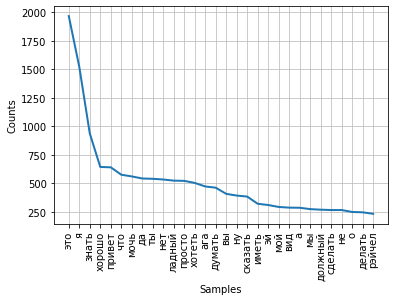

In [16]:
# Frequency Distribution Plot
import matplotlib.pyplot as plt
fdist.plot(30,cumulative=False)
plt.show()